# Distributed Q-Learning and SARSA

The goal of this assignment is to implement both single-core and distributed versions of two temporal difference (TD) reinforcement learning algorithms, Q-Learning and SARSA. In particuar, Q-Learning and SARSA will be run in a Markov Decision Process environment in order to compute policies that optimize expected infinite horizon discounted cummulative reward.

The relevant content about Q-Learning and SARSA are in the following course notes from CS533.

https://oregonstate.instructure.com/courses/1719746/files/74944693/download?wrap=1


## Recap of Q-Learning and SARSA 

Q-Learning and SARSA appear to be extremely similar algorithms at the code level. In particular, their update formulas are as follows:

\begin{equation}
\mbox{SARSA:  } Q(s,a) \leftarrow Q(s,a) + \alpha\cdot \left(r + \beta Q(s',a') - Q(s,a)\right) \\
\mbox{Q-Learning:  } Q(s,a) \leftarrow Q(s,a) + \alpha\cdot \left(r + \beta \max_a' Q(s',a') - Q(s,a)\right) 
\end{equation}
where $s'$ and $r$ are the next state and reward after taking action $a$ in state $s$. Further, for SARSA, $a'$ is the action that was taken by the agent in $s'$. 

While these updates a are similar, the algorithms are different in a fundamental way. SARSA is an on-policy algorithm, which aims to learn the value of the policy that is being used to collect data (we call this the behavior policy). In the case of policy optimization, this behavior policy is an exploration-exploitation policy. This is why $a'$ in the SARSA algorithm is based on the action actually taken by the behavior policy. 

Rather, Q-Learning is an off-policy algorithm, which can learn from any set of experience tuples, regardless of how they were collected. In particular, notice that Q-Learning is not sensitive to what action (if any) was taken in $s'$, while SARSA must be given the action that was actually taken in $s'$. Even if the exploration policy were completely random, Q-Learning will converge in the limit to an optimal policy under standard assumptions on the learning rate decay. 

The off-policy versus on-policy difference can lead the algorithms to sometimes learn different policies in practice. The assignment below will give you the opportunity to implement both SARSA and Q-Learning and to observe and explain such differences. After first implementing a single-core version of the algorithms, you will then implement a distributed version of Q-Learning. Note that the off-policy nature of Q-Learning makes it more directly compatible with distributed implementations compared to SARSA, since the experience need not come from a particular behavior policy. 

To complete the exercise, you need to finish all parts of this notebook. You also need to turn in a report---the notebook exercises will indicate what should be included in the report.  

In [1]:
# You will need to uncomment the following pip commands if the libraries need to be installed. 
# You may get some errors related to readchar, but they should not break the project.

#!pip install --user numpy
#!pip install --user gym
#!pip install --user tqdm

In [1]:
import ray
import time
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from random import randint, choice, uniform
import random
%matplotlib inline
import pickle
import numpy as np
import tqdm

***

## FrozenLake  
<span style="color:red">(The game code and transition probability is different from assignment 2)</span>  
We will use the FrozenLake environment as the MDP environment for this experiment. This is a type of gridworld environment, whose size (number of states) can be controlled by adjusting the grid dimensions. The environment is intended to model the process of navigating a frozen lake, while avoiding falling into holes with the objective of reaching a goal location. 

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are four different types of cells as indicated by the following cell labels: 

    - S labels the starting/initial cell, always in the top left corner
    
    - F labels frozen cells that are safe to step on

    - H labels holes and if the agent enters a hole cell there is a pentalty of -1000 and the episode ends

    - G labels the goal cell and when reached gives a reward of 1000 and the episode ends

- There are four possible actions (Left, Right, Down, Up). 

- The transition function moves the agent in the expected direction with 0.97 probability, and there is a 0.03 probability of transitioning to one of the other randomly selected directions. 

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. 

- Episodes end whenever the agent falls in a hole or reaches the goal. An end-of-episode is modeled by transitioning to a zero-reward terminal state (all actions lead to that state). 

The version we are using for assignment 3 is a modified version of the environment at the following location.   
  
Source: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py  

Execute the following cell to initialize the MDP environments. (You do not need to change the code in this part.)

In [2]:
import sys
from contextlib import closing

from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize, precision = 2)
#TransitionProb = [0.7, 0.1, 0.1, 0.1]
#TransitionProb = [1, 0, 0, 0]
TransitionProb = [0.97, 0.01, 0.01, 0.01]
def generate_row(length, h_prob):
    row = np.random.choice(2, length, p=[1.0 - h_prob, h_prob])
    row = ''.join(list(map(lambda z: 'F' if z == 0 else 'H', row)))
    return row


def generate_map(shape):
    """

    :param shape: Width x Height
    :return: List of text based map
    """
    h_prob = 0.1
    grid_map = []

    for h in range(shape[1]):

        if h == 0:
            row = 'SF'
            row += generate_row(shape[0] - 2, h_prob)
        elif h == 1:
            row = 'FF'
            row += generate_row(shape[0] - 2, h_prob)

        elif h == shape[1] - 1:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FG'
        elif h == shape[1] - 2:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FF'
        else:
            row = generate_row(shape[0], h_prob)

        grid_map.append(row)
        del row

    return grid_map

MAPS = {
    
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "Dangerous Hallway": [
        "SFFFFFFF",
        "FFFFFFFF",
        "HFHHHFFF",
        "HFHHHFFF",
        "HFHHHFFF",
        "HFHHHFFF",
        "HFFFFFFF",
        "FGFFFFFF"
    ],
    "16x16": [
        "SFFFFFFFFHFFFFHF",
        "FFFFFFFFFFFFFHFF",
        "FFFHFFFFHFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFFFFFFFF",
        "FFHHFFFFFFFHFFFH",
        "FFFFFFFFFFFFFFFF",
        "FFFFFHFFFFFFHFFF",
        "FFFFFHFFFFFFFFFH",
        "FFFFFFFHFFFFFFFF",
        "FFFFFFFFFFFFHFFF",
        "FFFFFFHFFFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFHFFFFHF",
        "FFFFFFFFFFHFFFFF",
        "FFFHFFFFFFFFFFFG",
    ],
    
    "32x32": [
        'SFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFFFFFFHFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFHFFFFFFFFHFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFHFHHFHFHFFFFFHFFFH',
        'FFFFHFFFFFFFFFFFFFFFHFHFFFFFFFHF',
        'FFFFFHFFFFFFFFFFHFFFFFFFFFFHFFFF',
        'FFHHFFFFHFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFHFFFFFFFFFFHFFFHFHFFFFFFFFHFF',
        'FFFFHFFFFFFHFFFFHFHFFFFFFFFFFFFH',
        'FFFFHHFHFFFFHFFFFFFFFFFFFFFFFFFF',
        'FHFFFFFFFFFFHFFFFFFFFFFFHHFFFHFH',
        'FFFHFFFHFFFFFFFFFFFFFFFFFFFFHFFF',
        'FFFHFHFFFFFFFFHFFFFFFFFFFFFHFFHF',
        'FFFFFFFFFFFFFFFFHFFFFFFFHFFFFFFF',
        'FFFFFFHFFFFFFFFHHFFFFFFFHFFFFFFF',
        'FFHFFFFFFFFFHFFFFFFFFFFHFFFFFFFF',
        'FFFHFFFFFFFFFHFFFFHFFFFFFHFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFFFFFFHFFFFFFFHFFFFFFFFFFFFFFH',
        'FFHFFFFFFFFFFFFFFFHFFFFFFFFFFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFHFFFFFFFHFFF',
        'FFHFFFFHFFFFFFFFFHFFFFFFFFFFFHFH',
        'FFFFFFFFFFHFFFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFHHFFHHHFFFHFFFF',
        'FFFFFFFFFFFFFFHFFFFHFFFFFFFHFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFHFFFFFFFFFFFFFFFFHFFHFFFFFF',
        'FFFFFFFHFFFFFFFFFHFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFFFFFHFFFFFFG',
    ]
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # BFS to check that it's a valid path.
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True

        tmp = arr[r][c]
        arr[r][c] = "#"

        # Recursively check in all four directions.
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        for x, y in directions:
            r_new = r + x
            c_new = c + y
            if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                continue

            if arr[r_new][c_new] not in '#H':
                if is_valid(arr, r_new, c_new):
                    arr[r][c] = tmp
                    return True

        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.

    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4"):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol
        self.nS = nS
        
        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        rew_hole = -1000
        rew_goal = 1000
        rew_step = -1
        
        exit = nrow * ncol
        P = {s : {a : [] for a in range(nA)} for s in range(nS + 1)}
        
        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'H':
                        li.append((1.0, exit, -1000, True))
                    elif letter in b'G':
                        li.append((1.0, exit, 1000, True))
                    else:
                        for b, p in zip([a, (a+1)%4, (a+2)%4, (a+3)%4], TransitionProb):
                            newrow, newcol = inc(row, col, b)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            rew = rew_step
                            li.append((p, newstate, rew, False))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        if self.s < self.nS:
            desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        else:
            outfile.write("exit\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
    

***
***
## Initializations

Run the following cell to initilize maps of different sizes. 

In [3]:
#map_4 = (MAPS["4x4"], 4)
#map_8 = (MAPS["8x8"], 8)
#map_32 = (MAPS["32x32"], 32)
#map_50 = (generate_map((50,50)), 50)
#map_110 = (generate_map((110,110)), 110)

map_DH = (MAPS["Dangerous Hallway"], 8)
map_16 = (MAPS["16x16"], 16)

MAP = map_16
map_size = MAP[1]
run_time = {}

## Helper Function
The following will be used to plot the performance of learning and display the learned value function. Note that both SARSA and Q-Learning produce Q-function tables, which store a value for each state-action pair. Given a Q-function $Q(s,a)$, the corresponding value function is given by $V(s)=\max_a Q(s,a)$. This relation is used to visualize the value function learned for the environment. 

In [4]:
def plot_result(total_rewards, learning_num, legend):
    print("\nLearning Performance:\n")
    episodes = []
    for i in range(len(total_rewards)):
        episodes.append(i * learning_num + 1)
        
    plt.figure(num = 1)
    fig, ax = plt.subplots()
    plt.plot(episodes, total_rewards)
    plt.title('performance')
    plt.legend(legend)
    plt.xlabel("Episodes")
    plt.ylabel("total rewards")
    plt.show()
    
def plot_image(q_table, MAP):
    
    best_value = np.max(q_table, axis = 1)[:-1].reshape((map_size,map_size))
    best_policy = np.argmax(q_table, axis = 1)[:-1].reshape((map_size,map_size))
    
    print("\n\nBest Q-value and Policy:\n")
    fig, ax = plt.subplots()
    im = ax.imshow(best_value)

    for i in range(best_value.shape[0]):
        for j in range(best_value.shape[1]):
            if MAP[i][j] in 'GH':
                arrow = MAP[i][j]
            elif best_policy[i, j] == 0:
                arrow = '<'
            elif best_policy[i, j] == 1:
                arrow = 'v'
            elif best_policy[i, j] == 2:
                arrow = '>'
            elif best_policy[i, j] == 3:
                arrow = '^'
            if MAP[i][j] in 'S':
                arrow = 'S ' + arrow
            text = ax.text(j, i, arrow,
                           ha = "center", va = "center", color = "black")
            
    cbar = ax.figure.colorbar(im, ax = ax)
    
    fig.tight_layout()
    plt.show() 
    
    

## Simulator

We now create a simulator corresponding to the environment that we want to train and test the agent in. The simulator always maintains a current state, which changes using the following functions:  
- simulator.reset(): Reset the simulator so that the current state is the initial state.   
- simulator.step(action): take the specified action in the current state, which returns the tuple (next_state, reward, done, info) and sets the internal current stae to be next_state. 

In [5]:
simulator = FrozenLakeEnv(desc = MAP[0])

***
# Non-Distributed RL Agents

In this part, you will implement Q-learning and SARSA on two maps: Dangerous Hall and the Size 16 map. 

$\epsilon$-greedy exploration will be used as the exploration strategy with a fixed value of $\epsilon$. 

- Suggested learning episodes ---  Dangerous Hall map = 30000 and Size 16 map = 100,000

A typical way to evaluate the learning performance of an RL agent is as follows. The agent will learning using an explore-exploit policy for "test_interval" number of episodes. After each "test_interval" learning episodes, exploration is turned off and the performance of the greedy policy is evaluated. This is done by defining the policy as $\pi(s)=\arg\max_a Q(s,a)$ and then running the policy for a specified number of episodes and averaging the results. 

- Evaluation --- by default testing is done every "test_interval" episodes, but testing can be turned off by setting the do_test argument to false. 
  
In this part of the assignment you need to do the following. 

- Use both SARSA and Q-Learning to learn policies for each of the two maps using learning rates of 0.001 and 0.1 (using the default value of $\epsilon$). 

- Use the better of the two learning rates to learning policies using SARSA and Q-Learning on each of the two maps using $\epsilon$ values of 0.3, 0.05.

### Your final report for the asignment should include the following. 

1. Provide the learning curves for the above experiments. Clearly label the curves by the parameters used. 

2. Did you observe differences for SARSA when using the two different learning rates? If there were significant differences, what were they and how can you explain them?  

3. Repeat (2) for Q-Learning.

4. Did you observe differences for SARSA when using different values of $\epsilon$? If there were significant differences, what were they and how do you explain them?

5. Repeat (4) for Q-Learning. 

6. For the map "Dangerous Hallway" did you observe differences in the policies learned by SARSA and Q-Learning for the two values of epsilon (there should be differences between Q-learning and SARSA for at least one value)? If you observed a difference, give your best explanation for why Q-learning and SARSA found different solutions.


***
## TDagent
The parent calss of Q-learning and SARSA

In [6]:
class agent():
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size, 
                 test_interval = 100, action_space = 4, beta = 0.999, do_test = True):
        self.beta = beta
        self.epsilon = epsilon
        self.test_interval = test_interval
        self.batch_num = learning_episodes // test_interval
        self.action_space = action_space
        self.state_space = map_size * map_size + 1
        self.q_table = np.zeros((self.state_space, self.action_space))
        self.learning_rate = learning_rate
        self.do_test = do_test
        
    def explore_or_exploit_policy(self, curr_state):
        #INSERT YOUR CODE HERE
        p = random.random()
        if p < self.epsilon:
            return np.random.choice(4)
        else:
            return self.q_table[curr_state].argmax()
        
    def greedy_policy(self, curr_state):
        #INSERT YOUR CODE HERE
        return self.q_table[curr_state].argmax()
    
    def learn_and_evaluate(self):
        total_rewards = []
        for i in tqdm.tqdm(range(self.batch_num), desc="Test Number"):
            #INSERT YOUR CODE HERE
            self.learn()
            reward = self.evaluate(self.greedy_policy)
            total_rewards.append(reward)
        
        return total_rewards, self.q_table
    
    def evaluate(self, policy_func, trials = 100, max_steps = 1000):
        
        total_reward = 0
        for _ in range(trials):
            simulator.reset()
            done = False
            steps = 0
            observation, reward, done, info = simulator.step(policy_func(0))
            total_reward += (self.beta ** steps) * reward
            steps += 1
            while not done and steps < 1000:
                observation, reward, done, info = simulator.step(policy_func(observation))
                total_reward += (self.beta ** steps) * reward
                steps += 1
        
        return total_reward / trials
    
    def learn(self):
        pass

## Q-learning Agent

In [7]:
class QLAgent(agent):
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size, test_interval = 100, action_space = 4, beta = 0.999, do_test = True):
        super().__init__(epsilon, learning_rate, learning_episodes, map_size, 
                         test_interval = test_interval, action_space = action_space, beta = beta, do_test = do_test)
        self.agent_name = "Q-learning Agent"
        
    def learn(self):
        for _ in range(self.test_interval):
            #INSERT YOUR CODE HERE
            simulator.reset()
            steps = 0
            s = 0
            a = self.explore_or_exploit_policy(s)
            ns, r, done, info = simulator.step(a)
            self.q_table[s][a] = self.q_table[s][a] + self.learning_rate * (r + self.beta * np.max(self.q_table[ns]) -  self.q_table[s][a])
            steps = steps + 1
            s = ns
            while not done and steps < 1000:
                a = self.explore_or_exploit_policy(s)
                ns, r, done, info = simulator.step(a)
                self.q_table[s][a] = self.q_table[s][a] + self.learning_rate * (r + self.beta * np.max(self.q_table[ns]) -  self.q_table[s][a])
                steps = steps + 1
                s = ns
            
            

Test Number: 100%|██████████| 300/300 [00:49<00:00,  6.08it/s]


Learning time:

49.33474373817444

Learning Performance:



<Figure size 432x288 with 0 Axes>

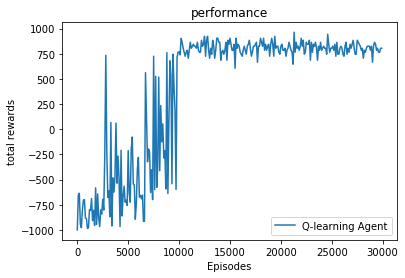



Best Q-value and Policy:



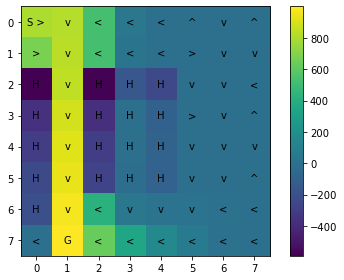

In [8]:
simulator.reset()

#INSERT YOUR CODE FOR INIT PARAMS HERE
learning_episodes = 30000
learning_rate = 0.001
epsilon = 0.3
test_interval = 100
do_test = True

ql_agent = QLAgent(epsilon, learning_rate, learning_episodes, map_size, test_interval = test_interval, do_test = do_test)
start_time = time.time()
total_rewards, q_table = ql_agent.learn_and_evaluate()
run_time['Q-learning agent'] = time.time() - start_time
print("Learning time:\n")
print(run_time['Q-learning agent'])
if do_test:
    plot_result(total_rewards ,ql_agent.test_interval, [ql_agent.agent_name])
plot_image(q_table, MAP[0])

## SARSA Agent

In [15]:
class SARSAagent(agent):
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size, 
                 test_interval = 100, action_space = 4, beta = 0.999, do_test = True):
        super().__init__(epsilon, learning_rate, learning_episodes, map_size,
                         test_interval = test_interval, action_space = action_space, beta = beta, do_test = do_test)
        self.agent_name = "SARSA Agent"
        
    def learn(self):
        for _ in range(self.test_interval):
            #INSERT YOUR CODE HERE
            simulator.reset()
            steps = 0
            s = 0
            a = self.explore_or_exploit_policy(s)
            ns, r, done, info = simulator.step(a)
            na = self.explore_or_exploit_policy(ns)
            self.q_table[s][a] = self.q_table[s][a] + self.learning_rate * (r + self.beta * self.q_table[ns][na] -  self.q_table[s][a])
            steps = steps + 1
            s = ns
            while not done and steps < 1000:
                a = self.explore_or_exploit_policy(s)
                ns, r, done, info = simulator.step(a)
                na = self.explore_or_exploit_policy(ns)
                self.q_table[s][a] = self.q_table[s][a] + self.learning_rate * (r + self.beta * self.q_table[ns][na] -  self.q_table[s][a])
                steps = steps + 1
                s = ns
            
            

Test Number: 100%|██████████| 300/300 [01:40<00:00,  2.98it/s]

Learning time:

100.83269238471985

Learning Performance:



<Figure size 432x288 with 0 Axes>

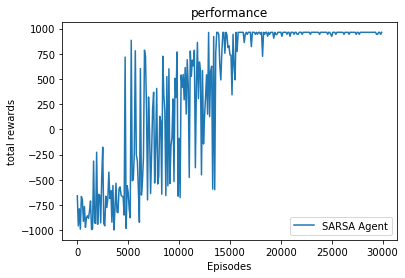



Best Q-value and Policy:



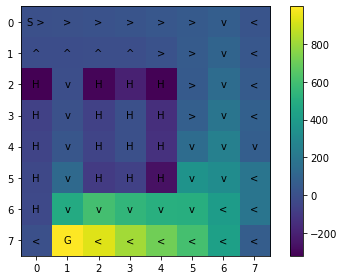

In [10]:
simulator.reset()
#INSERT YOUR CODE FOR INIT PARAMS HERE
learning_episodes = 30000
learning_rate = 0.001
epsilon = 0.3
test_interval = 100
do_test = True

sarsa_agent = SARSAagent(epsilon, learning_rate, learning_episodes, map_size,
                         test_interval = test_interval, do_test = do_test)
start_time = time.time()
total_rewards, q_table = sarsa_agent.learn_and_evaluate()
run_time['SARSA agent'] = time.time() - start_time
print("Learning time:\n")
print(run_time['SARSA agent'])
if do_test:
    plot_result(total_rewards, sarsa_agent.test_interval, [sarsa_agent.agent_name])
plot_image(q_table, MAP[0])

***
# Distibuted Q-Learning
***
## init Ray

In [7]:
ray.shutdown()
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=100000000, object_store_memory=1000000000, temp_dir = '~/ray_tmp')

2021-05-11 23:42:29,985	INFO resource_spec.py:212 -- Starting Ray with 181.05 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '10.9.1.45',
 'redis_address': '10.9.1.45:37859',
 'object_store_address': '/home/u71424/ray_tmp/session_2021-05-11_23-42-29_961525_26790/sockets/plasma_store',
 'raylet_socket_name': '/home/u71424/ray_tmp/session_2021-05-11_23-42-29_961525_26790/sockets/raylet',
 'webui_url': None,
 'session_dir': '~/ray_tmp/session_2021-05-11_23-42-29_961525_26790'}

## Distibuted Q-learning Agent 

Below you will implement a distributed Q-Learning algorithm, where both the learning and evaluation/testing is done in a distributed way. The goal is to demonstrate a speedup in learning (in terms of wall-clock time) by creating multiple workers to collect data and do the evaluation. We have provided a schema for how to implement this. 

- Main Agent: Setup all the wokrers and server and turn them on.  
- Collector: There is a simulator inside each collector. Their job is collecting exprience from the simulator, and sending the experience the Q-table server.  
- Evaluator: There is a simulator inside each evaluator. Their job is taking a Q-table from server, then testing the performace of the greedy policy and sending the results back to the server.  
- Server: It maintains the Q-table. It Takes expriences from collector and performs the appropriate learning updates. It also responds to the evaluator periodically when it is time to perform tests/evaluations.   
  
We have provided the Evaluator code, so you don't need to implement that yourself. However, understanding that code should be helpful for your implementation of other parts. 

After you complete the coding for this part, you need to peform evaluations on the two maps using the following number of workers: (collector workers, evaluator workers) = (2,4), (4,4), (8,4).  You can use $\epsilon = 0.1$ and the best of the learning rates that you considered. 

```python

"""

 +---------------+
 |               |
 |     Agent     |
 |               | initializes all the wokrers and server.
 |               |
 +---------------+
                                             
                                             
            +-----------+         +-----------+       +-----------+         +-----------+  
            |           |         |           |       |           |         |           |       
            |  Worker   |         |  Worker   |       |  Worker   |         |  Worker   |       
            |(Collector)|--------▷|(Collector)|------▷|(Collector)|--------▷|(Collector)|               
            |           |         |           |       |           |         |           |       
            +-----------+         +-----------+       +-----------+         +-----------+       
                  |                     |                   |                     |            
                  |                     |                   |                     |             
                  +-- batch Exprience --+---------+---------+-- batch Exprience --+             
                                                  |                                             
                                                  |
                                                  ▽
                                          +----------------+                                            
                                          |                |                                                     
                                          |  QL Server     |  
                                          |   (learner)    |                   
                                          +----------------+                   
                                                   |
                                                   |
                   +-------- Q-tbale -------+---------+---------+-- Q-tbale -------+ 
                   |                     |                   |                     |              
                   |                     |                   |                     | 
                   ▽                     ▽                   ▽                     ▽
            +-----------+         +-----------+       +-----------+         +-----------+  
            |           |         |           |       |           |         |           |       
            |  Worker   |         |  Worker   |       |  Worker   |         |  Worker   |       
            |(Evaluator)|         |(Evaluator)|       |(Evaluator)|         |(Evaluator)|               
            |           |         |           |       |           |         |           |       
            +-----------+         +-----------+       +-----------+         +-----------+                                                                                                                      
"""

```

In [8]:
@ray.remote    
class QLAgent_server(agent):
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size,
                 test_interval = 100, batch_size = 100, action_space = 4, beta = 0.999, do_test = True):
        super().__init__(epsilon, learning_rate, learning_episodes, map_size, 
                         test_interval = test_interval, action_space = action_space, beta = beta, do_test = do_test)
        self.collector_done = False
        self.evaluator_done = False
        self.learning_episodes = learning_episodes
        self.episode = 0
        self.reuslts = []
        self.batch_size = batch_size
        self.privous_q_tables = []
        self.results = [0] * (self.batch_num + 1)
        self.reuslt_count = 0
        
    def learn(self, experiences):
        #INSERT YOUR CODE HERE
        for s, a, r, ns in experiences:
            self.q_table[s][a] = self.q_table[s][a] + self.learning_rate * (r + self.beta * np.max(self.q_table[ns]) -  self.q_table[s][a])
        self.episode += 1
        
        if self.do_test:
            if self.episode // self.test_interval + 1 > len(self.privous_q_tables):
                self.privous_q_tables.append(self.q_table)
        return self.get_q_table()
        
    def get_q_table(self):
        if self.episode >= self.learning_episodes:
            self.collector_done = True
            
        return self.q_table, self.collector_done
    
    # evalutor
    def add_result(self, result, num):
        self.results[num] = result
    
    def get_reuslts(self):
        return self.results, self.q_table
    
    def ask_evaluation(self):
        if len(self.privous_q_tables) > self.reuslt_count:
            num = self.reuslt_count
            evluation_q_table = self.privous_q_tables[num]
            self.reuslt_count += 1
            return evluation_q_table, False, num
        else:
            if self.episode >= self.learning_episodes:
                self.evaluator_done = True
            return [], self.evaluator_done, None
    
@ray.remote    
def collecting_worker(server, simulator, epsilon, action_space = 4, batch_size = 100):
    def greedy_policy(curr_state):
        #INSERT YOUR CODE HERE
        return self.q_table[curr_state].argmax()
        
    def explore_or_exploit_policy(curr_state):
        #INSERT YOUR CODE HERE
        p = random.random()
        if p < epsilon:
            return np.random.choice(3)
        else:
            return q_table[curr_state].argmax()
        
    q_table, learn_done = ray.get(server.get_q_table.remote())
    while True:
        if learn_done:
            break
        #INSERT YOUR CODE HERE
        
        simulator.reset()
        done = False
        s = 0
        experience = []
        a = explore_or_exploit_policy(s)
        ns, r, done, info = simulator.step(a)
        experience.append((s, a, r, ns))
        s = ns
        while not done:
            a = explore_or_exploit_policy(s)
            ns, r, done, info = simulator.step(a)
            experience.append((s, a, r, ns))
            s = ns
        q_table, learn_done = ray.get(server.learn.remote(experience))
        
@ray.remote
def evaluation_worker(server, trials = 100, action_space = 4, beta = 0.999):
    def greedy_policy(curr_state):
        #INSERT YOUR CODE HERE
        return q_table[curr_state].argmax()
    
    while True:
        q_table, done, num = ray.get(server.ask_evaluation.remote())
        if done:
            break
        if len(q_table) == 0:
            continue
        total_reward = 0
        for _ in range(trials):
            simulator.reset()
            done = False
            steps = 0
            observation, reward, done, info = simulator.step(greedy_policy(0))
            total_reward += (beta ** steps) * reward
            steps += 1
            while not done:
                observation, reward, done, info = simulator.step(greedy_policy(observation))
                total_reward += (beta ** steps) * reward
                steps += 1
        server.add_result.remote(total_reward / trials, num)

class distributed_QL_agent():
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size, 
                 cw_num = 4, ew_num = 4, test_interval = 100, batch_size = 100,
                 action_space = 4, beta = 0.999, do_test = True):
        
        self.server = QLAgent_server.remote(epsilon, learning_rate, learning_episodes, map_size, 
                                               test_interval = test_interval, batch_size = batch_size, do_test = do_test)
        self.workers_id = []
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.cw_num = cw_num
        self.ew_num = ew_num
        self.agent_name = "Distributed Q-learning"
        self.do_test = do_test
        
    def learn_and_evaluate(self):
        workers_id = []
        
        for cw in tqdm.tqdm(range(self.cw_num), desc="collecting worker"):
            cwid = collecting_worker.remote(self.server, simulator, epsilon, action_space = 4, batch_size = self.batch_size / self.cw_num)
            workers_id.append(cwid)
        for ew in tqdm.tqdm(range(self.ew_num), desc="evaluation worker"):
            ewid = evaluation_worker.remote(self.server, trials = 100, action_space = 4, beta = 0.999)
            workers_id.append(ewid)
        #INSERT YOUR CODE HERE

        ray.wait(workers_id, len(workers_id))
        return ray.get(self.server.get_reuslts.remote())

evaluation worker: 100%|██████████| 4/4 [00:00<00:00, 989.16it/s]


Learning time:

92.68229794502258

Learning Performance:



<Figure size 432x288 with 0 Axes>

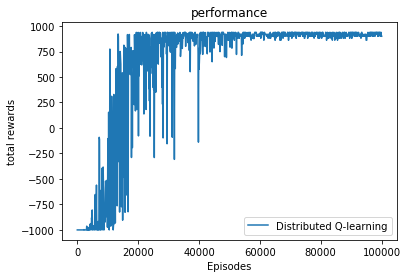



Best Q-value and Policy:



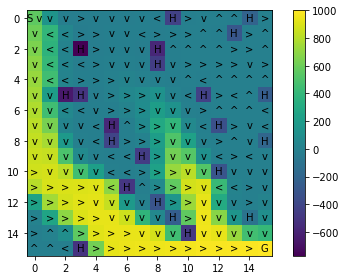

In [11]:
simulator.reset()
#INSERT YOUR CODE FOR INIT PARAMS HERE
learning_episodes = 100000
# learning_episodes = 30000
learning_rate = 0.001
# learning_rate = 0.001
# epsilon = 0.05
epsilon = 0.3
test_interval = 100
do_test = True
batch_size = 100

start_time = time.time()
distributed_ql_agent = distributed_QL_agent(epsilon, learning_rate, learning_episodes, map_size, 
                                            test_interval = test_interval, batch_size = batch_size,
                                            cw_num = 8, ew_num = 4, do_test = do_test)
total_rewards, q_table = distributed_ql_agent.learn_and_evaluate()
run_time['Distributed Q-learning agent'] = time.time() - start_time
print("Learning time:\n")
print(run_time['Distributed Q-learning agent'])
if do_test:
    plot_result(total_rewards, test_interval, [distributed_ql_agent.agent_name])
plot_image(q_table, MAP[0])

## Comparison of different approachs

Run the following cell to compare the running time of different approaches. 

In [ ]:
from copy import deepcopy
temp_dict = deepcopy(run_time)
print("All:")
for _ in range(len(temp_dict)):
    min_v = float('inf')
    for k, v in temp_dict.items():
        if v is None:
            continue
        if v < min_v:
            min_v = v
            name = k
    temp_dict[name] = float('inf')
    print(name + ": " + str(min_v))
    print()

### Include in your report the following: 

7. Show the value functions learned by the distributed methods for the best policies learned with $\epsilon$ equal to 0.3 and compare to those of the single-core method. Run the algorithm for the recommended number of episodes for each of the maps. Did the approaches produce similar results? 

8. Provide and compare the timing results for the single-core and distributed experiments, including the time to do the evaluations during learning. Describe the trends you observe as the number of workers increases. 

9. Provide and compare the timing results for the single-core and distributed experiments with the evaluation procedure turned off. That is, here you only want to provide timing results for the learning process without any interleaved evaluation. Compare the results with (8). 